In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
import shap
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,276,128,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,264,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,287,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,264,117,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [6]:
train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 37): [1051], (0, 21, 55): [1612], (0, 21, 57): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

C:\Users\Kalea\AppData\Local\Temp\ipykernel_44276\635274658.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [7]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3273
klasifikasi_perkara_encoded
0    1378
2    1251
3     289
4     193
1     162
Name: count, dtype: int64


In [8]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1050
klasifikasi_perkara_encoded
0    490
2    438
4     51
3     48
1     23
Name: count, dtype: int64


## Model

In [ ]:
model_scenario_name = "BiLSTM_13"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

### Model Preprocessing

In [10]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

In [11]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [12]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopwords Removal

In [13]:
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(remove_stopwords)
test_df['stopword_removal'] = test_df['normalized_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

In [14]:
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

train_df['stemmed_text'] = train_df['stopword_removal'].apply(stem_text)
test_df['stemmed_text'] = test_df['stopword_removal'].apply(stem_text)

### Tokenizer

In [15]:
# Tokenisasi
train_sequences = tokenizer.texts_to_sequences(train_df['stemmed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['stemmed_text'])

In [16]:
vocab_size = len(tokenizer.word_index) + 1  # 4 + 1 = 5
print("Vocabulary size:", vocab_size)

Vocabulary size: 14906


In [17]:
# Padding
# max_len = max(len(seq) for seq in train_sequences)
max_len = 1024
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [18]:
print(max_len)

1024


### Numerical Features

In [25]:
train_numerical = train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values.astype(np.float32)
test_numerical = test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values.astype(np.float32)

In [ ]:
# Ambil sampel background dan test
X_text_background = X_train_texts[:100]
X_num_background = train_numerical[:100]

X_text_test = X_test_texts[:10]
X_num_test = test_numerical[:10]

X_background = np.concatenate([X_text_background, X_num_background], axis=1)
X_test = np.concatenate([X_text_test, X_num_test], axis=1)

def model_predict(x):
    # Pisahkan: panjang teks = 1024
    text_input = x[:, :1024].astype(int)
    num_input = x[:, 1024:].astype(np.float32)
    return loaded_model.predict([text_input, num_input])


explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_test)

4/4 [==============================] - 1s 59ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

8350/8350 [==============================] - 482s 58ms/step


 10%|█         | 1/10 [08:07<1:13:07, 487.52s/it]

8350/8350 [==============================] - 576s 69ms/step


 20%|██        | 2/10 [17:49<1:12:22, 542.83s/it]

8350/8350 [==============================] - 593s 71ms/step


 30%|███       | 3/10 [27:48<1:06:22, 568.89s/it]

8350/8350 [==============================] - 586s 70ms/step


 40%|████      | 4/10 [37:42<57:51, 578.62s/it]  

8350/8350 [==============================] - 546s 65ms/step


 50%|█████     | 5/10 [46:54<47:24, 568.92s/it]

8350/8350 [==============================] - 573s 69ms/step


 60%|██████    | 6/10 [56:31<38:07, 571.91s/it]

8350/8350 [==============================] - 553s 66ms/step


 70%|███████   | 7/10 [1:05:50<28:22, 567.43s/it]

8350/8350 [==============================] - 547s 65ms/step


 80%|████████  | 8/10 [1:15:03<18:45, 562.93s/it]

8350/8350 [==============================] - 618s 74ms/step


 90%|█████████ | 9/10 [1:25:27<09:42, 582.04s/it]

8350/8350 [==============================] - 548s 66ms/step


100%|██████████| 10/10 [1:34:39<00:00, 567.98s/it]


In [ ]:

# Save shap_values to a file
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)


In [3]:
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [4]:
shap_values

[array([[ 0.1798724 , -0.16964455,  0.06688865, ...,  1.56270532,
         -0.09643159,  0.39930108],
        [ 0.19184231,  0.98657522,  0.05388908, ...,  1.45543704,
         -0.0876156 ,  0.46391205],
        [-0.5040988 ,  0.14122221, -0.11870724, ...,  0.72470395,
         -0.12922755, -0.41278633],
        ...,
        [-0.04755425, -0.0453522 , -0.08579431, ..., -0.07524499,
         -0.18700354,  1.31341013],
        [-0.05384237, -0.14596892, -0.03213627, ..., -0.62404739,
         -0.20860711, -0.60793368],
        [-0.36656127,  0.44852251,  0.1646133 , ..., -0.52310577,
          0.4350119 , -1.36877635]])]

In [5]:
print(type(shap_values))
print(len(shap_values) if isinstance(shap_values, (list, tuple)) else 'not list/tuple')
print([arr.shape for arr in shap_values] if isinstance(shap_values, (list, tuple)) else shap_values.shape)


<class 'list'>
1
[(10, 1029)]


In [6]:
# Contoh asumsi jumlah fitur teks 1024
num_text_features = 1024

# Buat nama fitur token (bisa hanya indeks atau kalau ada vocab)
feature_names_text = [f'token_{i}' for i in range(num_text_features)]

# Sudah ada nama fitur numerik
feature_names_num = ['klasifikasi_perkara', 'penuntut_umum', 'hakim', 'jumlah_saksi', 'maks_penjara']

# Gabungkan
feature_names_all = feature_names_text + feature_names_num


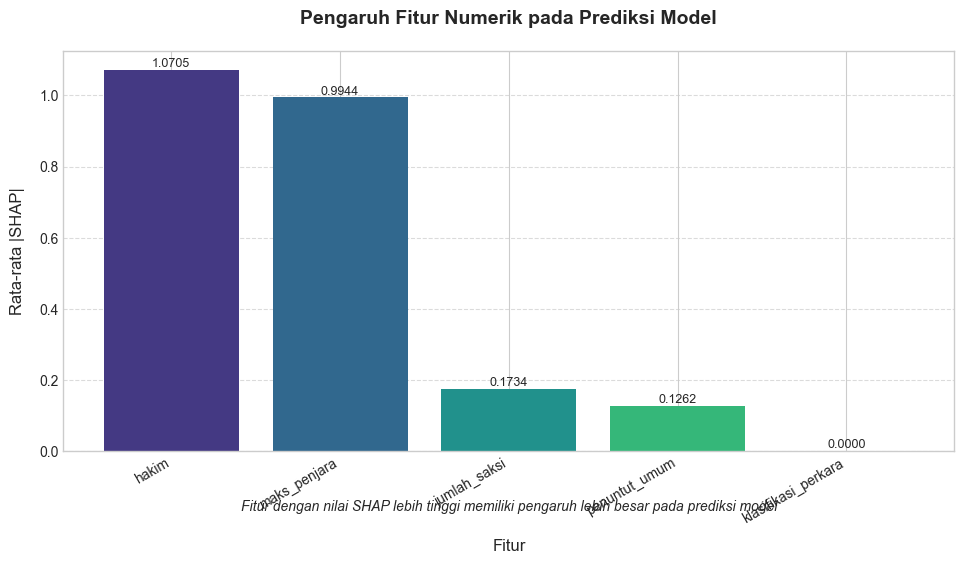


               TOP 20 TOKEN PALING BERPENGARUH
TOKEN ID   KATA                 NILAI SHAP     
------------------------------------------------------------
24         mengambil            0.49035
27         bin                  0.47952
17         barang               0.41498
26         paket                0.40117
18         uu                   0.36473
51         shabu                0.34774
47         menerima             0.34747
101        orang                0.33655
37         jalan                0.32604
13         alia                 0.32105
31         wib                  0.29879
11         sabu                 0.29334
6          i                    0.28790
55         kesatu               0.27761
12         dakwaan              0.27646
16         kuhp                 0.27463
70         seharga              0.27404
36         tanggal              0.26994
38         bukti                0.26951
66         handphon             0.26627



The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


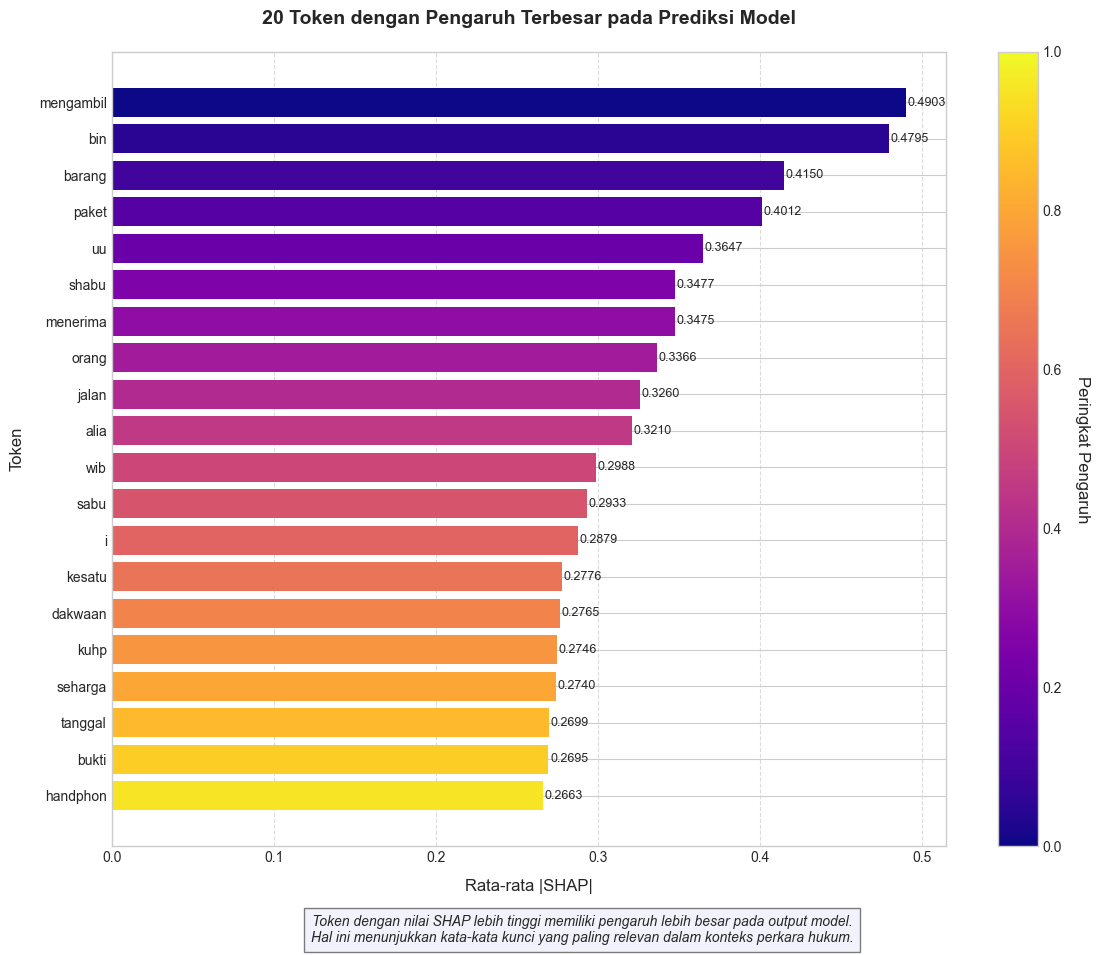

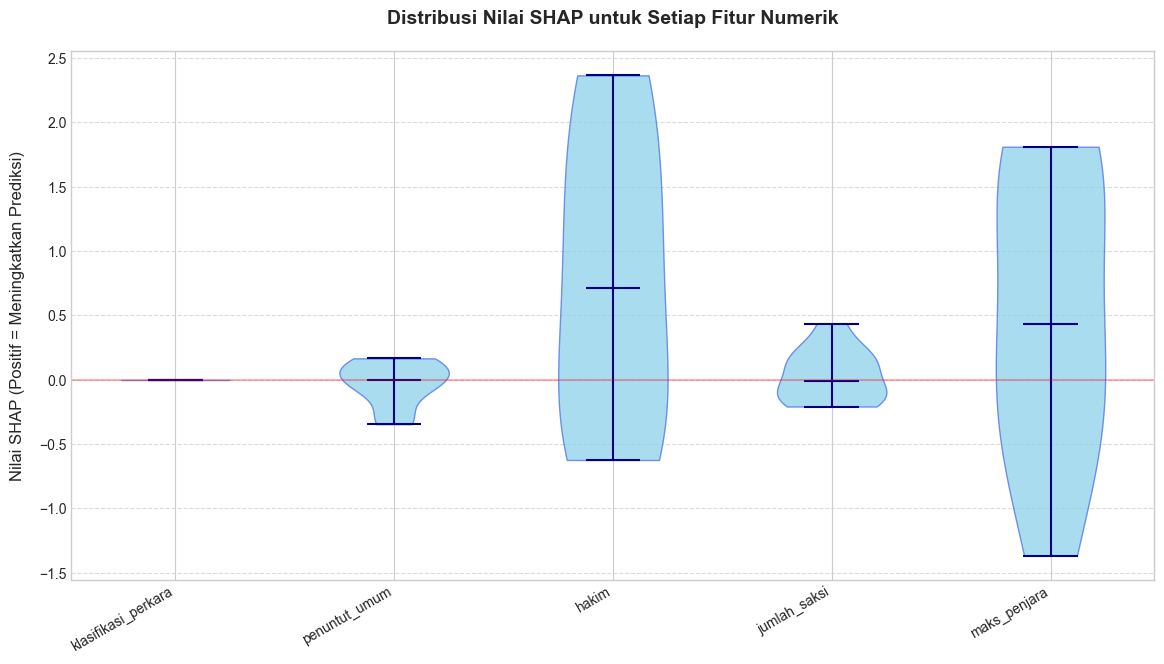

In [11]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Konfigurasi font 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Fitur numerik saja
shap_num_only = shap_values[0][:, 1024:]  

# Hitung rata-rata absolut SHAP untuk fitur numerik
mean_abs_shap_num = np.mean(np.abs(shap_num_only), axis=0)

# Nama fitur numerik
feature_names_num = ['klasifikasi_perkara', 'penuntut_umum', 'hakim', 'jumlah_saksi', 'maks_penjara']

# Urutkan fitur berdasarkan nilai SHAP
sorted_idx = np.argsort(mean_abs_shap_num)[::-1]
sorted_feature_names = [feature_names_num[i] for i in sorted_idx]
sorted_values = mean_abs_shap_num[sorted_idx]

# warna gradien
colors = sns.color_palette("viridis", len(feature_names_num))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(sorted_feature_names)), sorted_values, color=colors)

# nilai di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xticks(range(len(sorted_feature_names)))
ax.set_xticklabels(sorted_feature_names, rotation=30, ha='right')
ax.set_title('Pengaruh Fitur Numerik pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Fitur', labelpad=10)
ax.set_ylabel('Rata-rata |SHAP|', labelpad=10)

# anotasi dan grid
ax.annotate('Fitur dengan nilai SHAP lebih tinggi memiliki pengaruh lebih besar pada prediksi model', 
            xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=10, fontstyle='italic')
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout(pad=2)
plt.show()

# Ambil 1024 token pertama (fitur token teks)
shap_token_only = shap_values[0][:, :1024]

# Rata-rata absolut SHAP token
mean_abs_shap_token = np.mean(np.abs(shap_token_only), axis=0)

# Top 20 token dengan pengaruh tertinggi
top_20_idx = np.argsort(mean_abs_shap_token)[-20:][::-1]
top_20_values = mean_abs_shap_token[top_20_idx]

# Mapping token id ke kata dari tokenizer
index_word = tokenizer.index_word
top_20_tokens = [index_word.get(i, "[UNK]") for i in top_20_idx]

# Cetak hasil secara terformat
print("\n" + "="*60)
print(" "*15 + "TOP 20 TOKEN PALING BERPENGARUH")
print("="*60)
print(f"{'TOKEN ID':<10} {'KATA':<20} {'NILAI SHAP':<15}")
print("-"*60)
for idx, token, val in zip(top_20_idx, top_20_tokens, top_20_values):
    print(f"{idx:<10} {token:<20} {val:.5f}")
print("="*60 + "\n")

# colormap
cmap = plt.cm.get_cmap('plasma')
colors = [cmap(i/len(top_20_tokens)) for i in range(len(top_20_tokens))]

# Plot horizontal bar untuk top token
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(top_20_tokens)), top_20_values, color=colors)

# Tambahkan nilai pada bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', ha='left', va='center', fontsize=9)

# sumbu y terbalik sehingga token tertinggi di atas
ax.set_yticks(range(len(top_20_tokens)))
ax.set_yticklabels(top_20_tokens)
ax.invert_yaxis()

# gradien warna sebagai legenda
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Peringkat Pengaruh', rotation=270, labelpad=20)

ax.set_title('20 Token dengan Pengaruh Terbesar pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Rata-rata |SHAP|', labelpad=10)
ax.set_ylabel('Token', labelpad=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# anotasi penjelasan
plt.figtext(0.5, 0.01, 
            "Token dengan nilai SHAP lebih tinggi memiliki pengaruh lebih besar pada output model.\n"
            "Hal ini menunjukkan kata-kata kunci yang paling relevan dalam konteks perkara hukum.",
            ha="center", fontsize=10, fontstyle='italic', bbox={"facecolor":"lavender", "alpha":0.5, "pad":5})

fig.tight_layout(rect=[0, 0.03, 1, 0.97], pad=2)
plt.show()


# plot violin untuk melihat distribusi nilai SHAP untuk fitur numerik
fig, ax = plt.subplots(figsize=(12, 7))
data_to_plot = []
for i in range(shap_num_only.shape[1]):
    data_to_plot.append(shap_num_only[:, i])

violin_parts = ax.violinplot(data_to_plot, showmedians=True)

# Kustomisasi violin plot
for pc in violin_parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('royalblue')
    pc.set_alpha(0.7)

for partname in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    vp = violin_parts[partname]
    vp.set_edgecolor('navy')
    vp.set_linewidth(1.5)

ax.set_xticks(range(1, len(feature_names_num) + 1))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Distribusi Nilai SHAP untuk Setiap Fitur Numerik', fontweight='bold', pad=20)
ax.set_ylabel('Nilai SHAP (Positif = Meningkatkan Prediksi)', labelpad=10)
ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout(pad=2)
plt.show()